Статистический анализ данных датасета AAUP - средние зарплаты и компенсации преподавательского состава из 1073 университетов США.

In [1]:
from google.colab import files
files.upload()


Saving AAUP.xlsx to AAUP.xlsx


{'AAUP.xlsx': b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00O\x13\xac\x05u\x01\x00\x00\\\x05\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [3]:
import math


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import statsmodels.api as sm
from scipy import stats as st
from scipy.stats import skew, kurtosis, norm, chi2, f, pearsonr, spearmanr, kendalltau, rankdata, t

# 1. Описательные статистики


* A5 - Average salary - full professors
* A7 - Average salary - assistant professors
* A8 - Average salary - all ranks

In [5]:
df = pd.read_excel("AAUP.xlsx", sheet_name="A - aaup", engine="openpyxl")

list_A5 = df["A5"].dropna().astype(float).tolist()
list_A7 = df["A7"].dropna().astype(float).tolist()
list_A8 = df["A8"].dropna().astype(float).tolist()

print(list_A5[:10])
print(list_A7[:10])
print(list_A8[:10])


[454.0, 686.0, 533.0, 612.0, 442.0, 441.0, 466.0, 580.0, 498.0, 506.0]
[362.0, 432.0, 329.0, 414.0, 310.0, 310.0, 351.0, 374.0, 322.0, 359.0]
[382.0, 508.0, 415.0, 498.0, 350.0, 388.0, 396.0, 455.0, 401.0, 411.0]


In [6]:
for name, arr in zip(
    ["A5","A7","A8"],
    [list_A5, list_A7, list_A8]
):
    arr = np.array(arr)
    print(f"Метрики для {name}:")

    mean_val = round(np.mean(arr), 7)
    var_val  = round(np.var(arr, ddof=1), 7)
    std_val  = round(np.std(arr, ddof=1), 7)
    skew_val = round(skew(arr, bias=False), 7)
    kurt_val = round(kurtosis(arr, bias=False, fisher=True), 7)

    print("Среднее:", mean_val)
    print("Дисперсия:", var_val)
    print("СКО:", std_val)
    print("Асимметрия:", skew_val)
    print("Эксцесс:", kurt_val)
    print()

Метрики для A5:
Среднее: 526.4836906
Дисперсия: 13868.8563102
СКО: 117.7661085
Асимметрия: 0.679599
Эксцесс: 0.5385361

Метрики для A7:
Среднее: 355.0885368
Дисперсия: 2904.2897285
СКО: 53.8914625
Асимметрия: 0.4479978
Эксцесс: 0.4395453

Метрики для A8:
Среднее: 428.0326188
Дисперсия: 8217.6211365
СКО: 90.6510956
Асимметрия: 0.8202883
Эксцесс: 0.9859227



* Средняя зарплата полных профессоров (526.48) значительно выше, чем у ассистентов (355.09)
* Группа полных профессоров показывает гораздо больший разброс доходов (дисперсия 13868.86), чем группа ассистентов (дисперсия 2904.29), что указывает на большую разницу в оплате труда внутри высшего звена
* Для всех трех групп коэффициент асимметрии положителен, что указывает на смещение распределений вправо. В выборке преобладают зарплаты ниже среднего уровня, но присутствуют отдельные очень высокие значения


In [7]:
arr_A7 = np.array(list_A7)
n = len(arr_A7)

print(f"Анализируемый признак A7 Средняя зарплата - ассистенты")


bins = [195, 230, 265, 300, 335, 370, 405, 440, 475, 510, 545, 580]
k = len(bins) - 1

counts, _ = np.histogram(arr_A7, bins)


relative_frequencies = counts / n


cumulative_frequencies = np.cumsum(counts)

relative_cumulative_frequencies = cumulative_frequencies / n


lower_bounds = bins[:-1]
upper_bounds = bins[1:]
interval_number = np.arange(1, k + 1)


frequency_table = pd.DataFrame({
    'Номер интервала': interval_number,
    'Нижняя граница': lower_bounds,
    'Верхняя граница': upper_bounds,
    'Частота': counts,
    'Относит. частота': relative_frequencies.round(4),
    'Накопл. частота': cumulative_frequencies,
    'Относит. накопл. частота': relative_cumulative_frequencies.round(4)
})


frequency_table = pd.concat([frequency_table])

frequency_table

Анализируемый признак A7 Средняя зарплата - ассистенты


,Номер интервала,Нижняя граница,Верхняя граница,Частота,Относит. частота,Накопл. частота,Относит. накопл. частота
0,1,195,230,3,0.0028,3,0.0028
1,2,230,265,30,0.0280,33,0.0308
2,3,265,300,128,0.1193,161,0.1500
3,4,300,335,231,0.2153,392,0.3653
4,5,335,370,285,0.2656,677,0.6309
5,6,370,405,206,0.1920,883,0.8229
6,7,405,440,129,0.1202,1012,0.9432
7,8,440,475,32,0.0298,1044,0.9730
8,9,475,510,19,0.0177,1063,0.9907
9,10,510,545,8,0.0075,1071,0.9981


* У ассистентов зарплата часто находится в интервале от 335 до 370 единиц

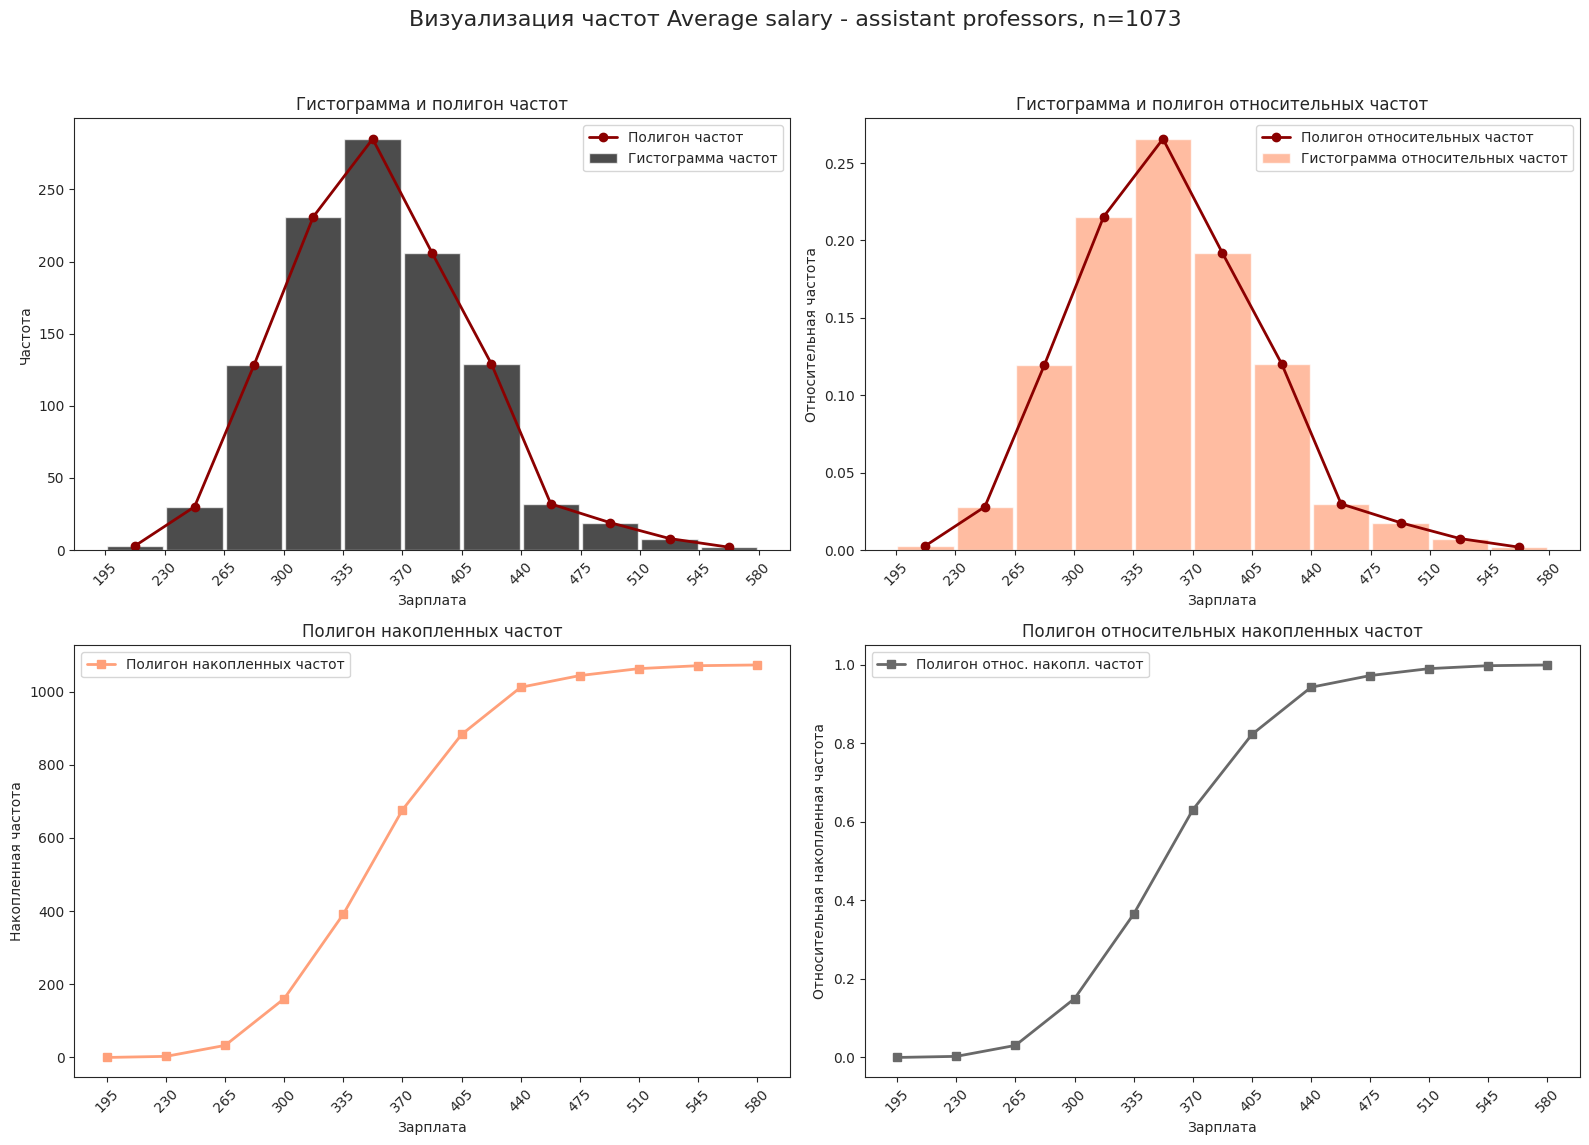

In [8]:
bins = np.array(bins)
bin_centers = (bins[:-1] + bins[1:]) / 2

sns.set_style("ticks")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Визуализация частот Average salary - assistant professors, n={n}', fontsize=16)

for ax in axes.flat:
    ax.set_xticks(bins)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('Зарплата')


ax1 = axes[0, 0]
width = bins[1] - bins[0]


ax1.bar(bin_centers, counts, width=width * 0.95, color='black', edgecolor='white', alpha=0.7,
        label='Гистограмма частот')
ax1.plot(bin_centers, counts, color='darkred', marker='o', linestyle='-', linewidth=2,
         label='Полигон частот')

ax1.set_ylabel('Частота')
ax1.set_title('Гистограмма и полигон частот')
ax1.legend()




ax2 = axes[0, 1]


ax2.bar(bin_centers, relative_frequencies, width=width * 0.95, color='lightsalmon', edgecolor='white', alpha=0.7,
        label='Гистограмма относительных частот')
ax2.plot(bin_centers, relative_frequencies, color='darkred', marker='o', linestyle='-', linewidth=2,
         label='Полигон относительных частот')

ax2.set_ylabel('Относительная частота')
ax2.set_title('Гистограмма и полигон относительных частот')
ax2.legend()


ax3 = axes[1, 0]

x_poly_cum = np.insert(bins[1:], 0, bins[0])
y_poly_cum = np.insert(cumulative_frequencies, 0, 0)


ax3.plot(x_poly_cum, y_poly_cum, color='lightsalmon', marker='s', linestyle='-', linewidth=2,
         label='Полигон накопленных частот')

ax3.set_ylabel('Накопленная частота')
ax3.set_title('Полигон накопленных частот')
ax3.legend()


ax4 = axes[1, 1]


y_poly_ogive = np.insert(relative_cumulative_frequencies, 0, 0)


ax4.plot(x_poly_cum, y_poly_ogive, color='dimgray', marker='s', linestyle='-', linewidth=2,
         label='Полигон относ. накопл. частот')

ax4.set_ylabel('Относительная накопленная частота')
ax4.set_title('Полигон относительных накопленных частот')
ax4.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



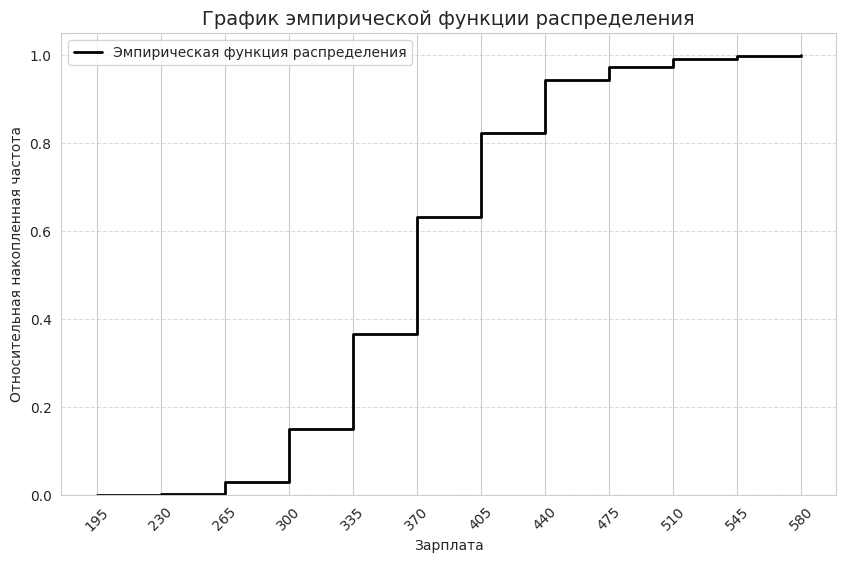

In [9]:
relative_cumulative_frequencies = np.array([0.0028, 0.0308, 0.1500, 0.3653, 0.6309, 0.8229, 0.9432, 0.9730, 0.9907, 0.9981, 1.0000])

x_fnx = bins

y_fnx = np.insert(relative_cumulative_frequencies, 0, 0.0)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

plt.step(x_fnx, y_fnx, where='post', color='black', linewidth=2,
         label='Эмпирическая функция распределения')

plt.title(f'График эмпирической функции распределения', fontsize=14)
plt.xlabel('Зарплата')
plt.ylabel('Относительная накопленная частота')

plt.xticks(bins, rotation=45)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# 2. Интервальные оценки

In [10]:
X_bar = 355.0885368
S = 53.8914625
n = 1073

alphas = [0.01, 0.05, 0.1]

SE = S / np.sqrt(n)


for alpha in alphas:
    Z_critical = norm.ppf(1 - alpha / 2)
    delta = Z_critical * SE

    lower_bound = X_bar - delta
    upper_bound = X_bar + delta

    print(
        f"{alpha}: "
        f"{lower_bound:.4f}; {upper_bound:.4f}"
    )


0.01: 350.8508; 359.3263
0.05: 351.8640; 358.3131
0.1: 352.3824; 357.7947


* С доверительной вероятностью 95% истинная средняя зарплата ассистентов профессоров находится в интервале [351.8640; 358.3131]

In [11]:
S_sq = 2904.2897285
n = 1073
df = n - 1

alphas = [0.01, 0.05, 0.1]
constant_numerator = df * S_sq

print("Доверительные интервалы для дисперсии")

for alpha in alphas:
    chi2_alpha_half = chi2.ppf(alpha / 2, df)
    chi2_1_alpha_half = chi2.ppf(1 - alpha / 2, df)

    L_var = constant_numerator / chi2_1_alpha_half
    U_var = constant_numerator / chi2_alpha_half

    print(
        f"{alpha}: "
        f"{L_var:.4f}; {U_var:.4f}"
    )


Доверительные интервалы для дисперсии
0.01: 2605.3040; 3255.0296
0.05: 2673.2894; 3166.7391
0.1: 2708.9940; 3122.7931


* Узкие границы доверительного интервала [2673.2894; 3166.7391] подтверждают высокую точность полученной оценки дисперсии равной 2904.2897285

In [12]:
n1 = 1073
X1_bar = 355.0885368
S1_sq = 2904.2897285

n2 = 1073
X2_bar = 428.0326188
S2_sq = 8217.6211365

alphas = [0.01, 0.05, 0.10]

diff_means = X2_bar - X1_bar

SE_diff_sq = (S1_sq / n1) + (S2_sq / n2)
SE_diff = np.sqrt(SE_diff_sq)

print("Доверительные интервалы для разности мат. ожиданий")

for alpha in alphas:
    Z_critical = norm.ppf(1 - alpha / 2)
    delta = Z_critical * SE_diff

    lower_bound = diff_means - delta
    upper_bound = diff_means + delta

    print(
        f"{alpha}: "
        f"{lower_bound:.4f}; {upper_bound:.4f}"
    )


Доверительные интервалы для разности мат. ожиданий
0.01: 64.6512; 81.2370
0.05: 66.6340; 79.2542
0.1: 67.6485; 78.2397


* Доверительный интервал для разности мат. ожиданий признаков A8 и A7 при уровне значимости 0.05 равен [66.6340; 79.2542]. Интервал полностью лежит в положительной области и не включает ноль => можно утверждать, что средняя зарплата по всем рангам статистически значимо выше зарплаты ассистентов

In [13]:
n1 = 1073
S1_sq = 2904.2897285

n2 = 1073
S2_sq = 8217.6211365

df1 = n1 - 1
df2 = n2 - 1

alphas = [0.01, 0.05, 0.10]

F_ratio_nablyud = S2_sq / S1_sq

print("Доверительные интервалы для отношения дисперсий")


for alpha in alphas:
    F_alpha_half = f.ppf(alpha / 2, df2, df1)
    F_1_alpha_half = f.ppf(1 - alpha / 2, df2, df1)

    lower_bound = F_ratio_nablyud / F_1_alpha_half
    upper_bound = F_ratio_nablyud / F_alpha_half

    print(
        f"{alpha}: "
        f"{lower_bound:.4f}; {upper_bound:.4f}"
    )


Доверительные интервалы для отношения дисперсий
0.01: 2.4172; 3.3120
0.05: 2.5101; 3.1895
0.1: 2.5589; 3.1287


* Довертельный интервал для отношения дисперсий признаков А8 и А7 при уровне значимости 0.05 равен [2.5101; 3.1895]. Интервал не содержит единицу и превышает её => разброс зарплат в общем составе преподавателей в 2.5–3 раза выше, чем в группе ассистентов, что указывает на большую неоднородность доходов при включении более высоких должностей

# 3. Проверка статистических гипотез о математических ожиданиях и дисперсиях


In [14]:
X_bar = 355.0885368
S = 53.8914625
n = 1073
SE = S / np.sqrt(n)

m0_values = [356, 345, 365]
alpha = 0.1


for m0 in m0_values:
    Z_nablyud = (X_bar - m0) / SE
    p_value = 2 * norm.sf(abs(Z_nablyud))

    print(f"m0 = {m0}")
    print(f"Zнабл = {Z_nablyud:.4f}")
    print(f"p-value = {p_value:.6f}")
    print()

m0 = 356
Zнабл = -0.5540
p-value = 0.579571

m0 = 345
Zнабл = 6.1321
p-value = 0.000000

m0 = 365
Zнабл = -6.0245
p-value = 0.000000



* Статистический тест подтвердил, что истинная средняя зарплата не имеет значимых отличий от значения 356 p−value = 0.579571, что согласуется с ранее рассчитанным доверительным интервалом

In [15]:
X_bar = 355.0885368
S_sq = 2904.2897285
S = 53.8914625
n = 1073
df = n - 1

alpha = 0.1

s0_values = [54.0, 50.0, 58.0]
s0_sq_values = [s**2 for s in s0_values]
constant_numerator = df * S_sq


for s0, s0_sq in zip(s0_values, s0_sq_values):
    chi2_nablyud = constant_numerator / s0_sq

    if chi2_nablyud > df:
        p_value_tail = chi2.sf(chi2_nablyud, df)
    else:
        p_value_tail = chi2.cdf(chi2_nablyud, df)

    p_value = 2 * p_value_tail

    print(f"s0 = {s0:.1f}")
    print(f"хиквнабл = {chi2_nablyud:.4f}")
    print(f"p-value = {p_value:.6e}")
    print()

s0 = 54.0
хиквнабл = 1067.6950
p-value = 9.372748e-01

s0 = 50.0
хиквнабл = 1245.3594
p-value = 3.522183e-04

s0 = 58.0
хиквнабл = 925.5049
p-value = 9.461550e-04



* Гипотеза: стандартное отклонение равно 54.0 - не была отклонена (p−value=9.372748e-01)

In [16]:
alphas = [0.01, 0.05, 0.10]

diff_means = X2_bar - X1_bar
SE_diff_sq = (S1_sq / n1) + (S2_sq / n2)
SE_diff = np.sqrt(SE_diff_sq)

Z_nablyud = diff_means / SE_diff
p_value = 2 * norm.sf(abs(Z_nablyud))

print(f"Zнабл = {Z_nablyud:.4f}")
print(f"p-value = {p_value:.10f}\n")

Zнабл = 22.6569
p-value = 0.0000000000



* Применение Z-критерия показало статистически значимое различие в уровнях оплаты труда. Cредняя зарплата по всем рангам существенно и неслучайно выше зарплаты ассистентов

In [17]:
alphas = [0.01, 0.05, 0.10]

S_max_sq = max(S1_sq, S2_sq)
S_min_sq = min(S1_sq, S2_sq)

df_num = n2 - 1 if S_max_sq == S2_sq else n1 - 1
df_den = n1 - 1 if S_min_sq == S1_sq else n2 - 1

F_nablyud = S_max_sq / S_min_sq
p_value = 2 * f.sf(F_nablyud, df_num, df_den)

print("Проверка гипотезы о равенстве дисперсий")
print(f"Fнабл = {F_nablyud:.4f}")
print(f"p-value = {p_value:.10f}\n")

Проверка гипотезы о равенстве дисперсий
Fнабл = 2.8295
p-value = 0.0000000000



* Использование F-критерия Фишера подтвердило, что дисперсии зарплат в этих двух группах не равны. Это доказывает, что при включении в анализ высшего преподавательского состава разброс доходов увеличивается почти в 3 раза.

# 4. Критерии согласия


In [18]:
lower_bounds = [195.0, 230.0, 265.0, 300.0, 335.0, 370.0, 405.0, 440.0, 475.0, 510.0, 545.0]
upper_bounds = [230.0, 265.0, 300.0, 335.0, 370.0, 405.0, 440.0, 475.0, 510.0, 545.0, 580.0]
counts = [3, 30, 128, 231, 285, 206, 129, 32, 19, 8, 2]

p_sum = 0
n_theor_sum = 0

for i in range(len(counts)):
    A = lower_bounds[i]
    B = upper_bounds[i]
    n_i = counts[i]

    w_i = n_i / n

    p_i = norm.cdf(B, loc=X_bar, scale=S) - norm.cdf(A, loc=X_bar, scale=S)

    if i == len(counts) - 1:
        p_i = 1 - norm.cdf(lower_bounds[i], loc=X_bar, scale=S)

    n_i_theor = n * p_i

    p_sum += p_i
    n_theor_sum += n_i_theor

    print(
        f"{i+1:2d} "
        f"{A:6.1f} "
        f"{B:6.1f} "
        f"{n_i:4d} "
        f"{w_i:.4f} "
        f"{p_i:.6f}"
    )

 1  195.0  230.0    3 0.0028 0.008654
 2  230.0  265.0   30 0.0280 0.037155
 3  265.0  300.0  128 0.1193 0.106045
 4  300.0  335.0  231 0.2153 0.201324
 5  335.0  370.0  285 0.2656 0.254329
 6  370.0  405.0  206 0.1920 0.213823
 7  405.0  440.0  129 0.1202 0.119626
 8  440.0  475.0   32 0.0298 0.044520
 9  475.0  510.0   19 0.0177 0.011015
10  510.0  545.0    8 0.0075 0.001811
11  545.0  580.0    2 0.0019 0.000213


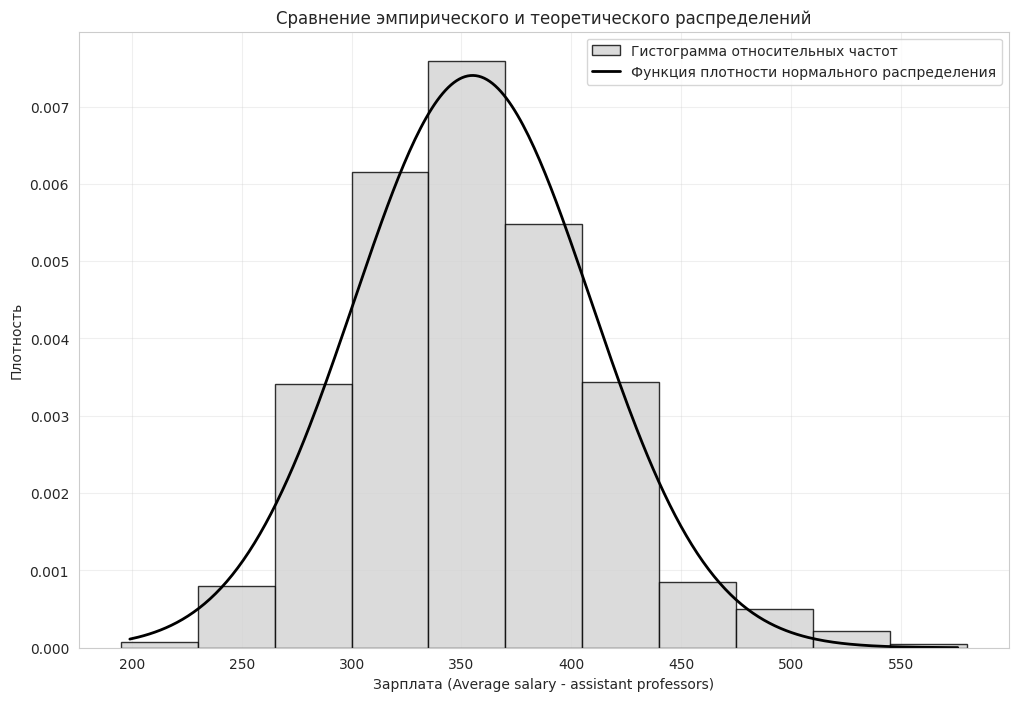

In [19]:
arr = np.array(list_A7)

plt.figure(figsize=(12, 8))

plt.hist(
    arr,
    bins=bins,
    density=True,
    color='lightgray',
    edgecolor='black',
    alpha=0.8,
    label='Гистограмма относительных частот'
)


x = np.linspace(min(arr), max(arr), 300)
plt.plot(
    x,
    norm.pdf(x, loc=X_bar, scale=S),
    color='black',
    linewidth=2,
    label='Функция плотности нормального распределения'
)

plt.xlabel('Зарплата (Average salary - assistant professors)')
plt.ylabel('Плотность')
plt.title('Сравнение эмпирического и теоретического распределений')
plt.legend()
plt.grid(alpha=0.3)

plt.show()


In [20]:
data_A7 = np.array(list_A7)
n = len(data_A7)
alphas = [0.01, 0.05, 0.10]
df = 2

b1_calc = skew(data_A7, bias=True)
b2_calc = kurtosis(data_A7, bias=True)

JB_nablyud = (n / 6) * (b1_calc**2 + (b2_calc**2) / 4)
p_value = chi2.sf(JB_nablyud, df)


print(f"Выборочное значение статистики (JB_obs): {JB_nablyud:.4f}")
print(f"p-value: {p_value:.6f}")

Выборочное значение статистики (JB_obs): 44.1322
p-value: 0.000000


* Критерий Харке-Бера подтвердил, что отклонение формы распределения от теоретической является системным, а не случайным. Гипотеза о нормальности распределения отклоняется

# 5. Проверка однородности выборок

In [21]:
data_A7 = np.array(list_A7)
data_A8 = np.array(list_A8)
n = len(data_A7)

differences = data_A7 - data_A8
S_plus = np.sum(differences > 0)
S_minus = np.sum(differences < 0)
n_prime = S_plus + S_minus

S_nablyud = min(S_plus, S_minus)

mu = n_prime / 2
sigma = np.sqrt(n_prime / 4)

Z_nablyud = (S_nablyud + 0.5 - mu) / sigma
p_value = 2 * norm.cdf(Z_nablyud)

alphas = [0.01, 0.05, 0.10]


print(f"Выборочное значение Z-статистики: {Z_nablyud:.4f}")
print(f"Рассчитанный p-value: {p_value:.8f}")
print()

Выборочное значение Z-статистики: -32.5430
Рассчитанный p-value: 0.00000000



*  Отвергаем гипотезу о равенстве распределений на всех уровнях значимости

In [22]:
bins = [195.0, 230.0, 265.0, 300.0, 335.0, 370.0, 405.0, 440.0, 475.0, 510.0, 545.0, 580.0, 615.0]

counts, _ = np.histogram(data_A8, bins)
counts[0] += np.sum(data_A8 < bins[0])
counts[-1] += np.sum(data_A8 > bins[-1])

print(counts.tolist())

[0, 7, 42, 88, 175, 180, 166, 123, 82, 85, 65, 60]


In [23]:
n2 = 1073
data_A8_freq = [0, 7, 42, 88, 175, 180, 166, 123, 82, 85, 65, 60]

w2 = [round(count / n2, 4) for count in data_A8_freq]

print(w2)

[0.0, 0.0065, 0.0391, 0.082, 0.1631, 0.1678, 0.1547, 0.1146, 0.0764, 0.0792, 0.0606, 0.0559]


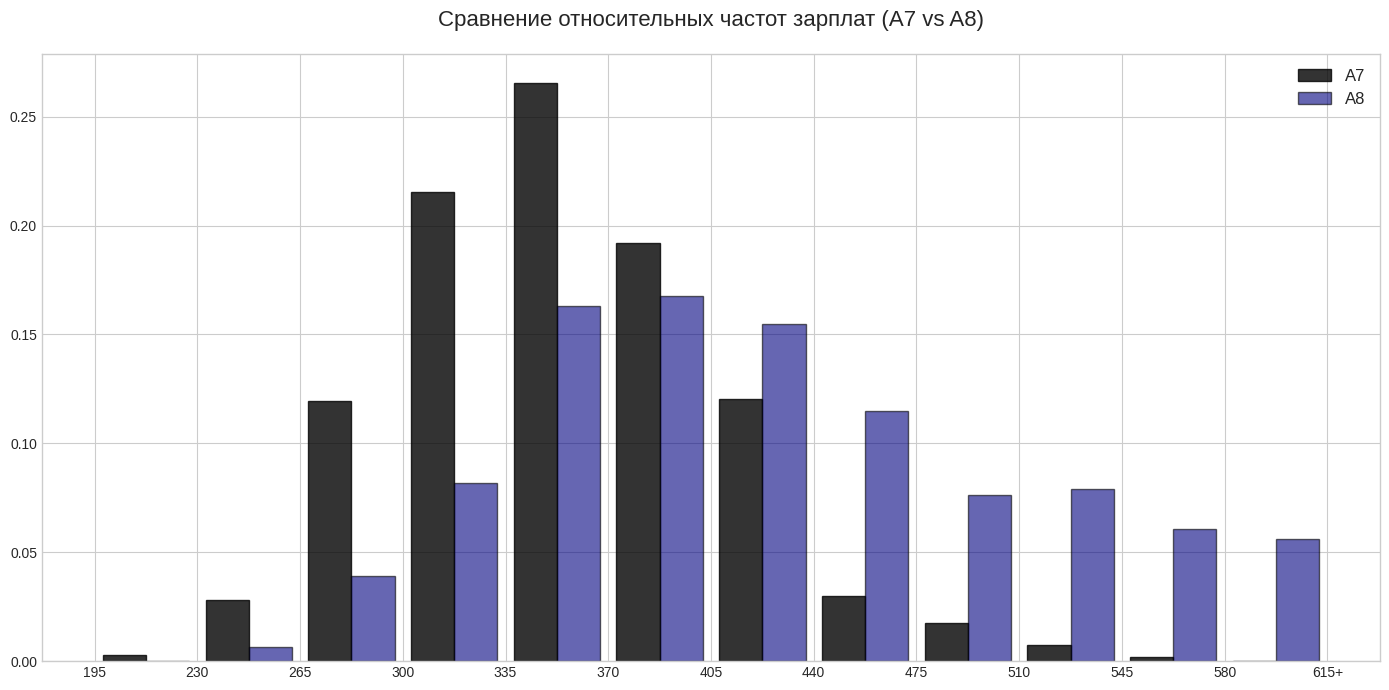

In [24]:
n = 1073
h = 35.0
low_bounds = np.array([195.0, 230.0, 265.0, 300.0, 335.0, 370.0, 405.0, 440.0, 475.0, 510.0, 545.0, 580.0])
w_A7 = np.array([3, 30, 128, 231, 285, 206, 129, 32, 19, 8, 2, 0]) / n
w_A8 = np.array([0, 7, 42, 88, 175, 180, 166, 123, 82, 85, 65, 60]) / n

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7))

width = h * 0.42
centers = low_bounds + h / 2


plt.bar(centers - width/2, w_A7, width=width, color='black', alpha=0.8, edgecolor='black', label='A7')
plt.bar(centers + width/2, w_A8, width=width, color='navy', alpha=0.6, edgecolor='black', label='A8')

x_ticks = np.append(low_bounds, low_bounds[-1] + h)
x_labels = [f'{x:.0f}' for x in x_ticks[:-1]] + ['615+']

plt.xticks(x_ticks, x_labels)
plt.title('Сравнение относительных частот зарплат (A7 vs A8)', fontsize=16, pad=20)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [25]:
observed = np.array([
    [9, 1], [122, 36], [347, 147], [353, 251],
    [183, 242], [42, 158], [15, 113], [2, 76], [0, 49]
])


row_sums = observed.sum(axis=1)
col_sums = observed.sum(axis=0)
n_total = observed.sum()
expected = np.outer(row_sums, col_sums) / n_total


chi2_obs = ((observed - expected)**2 / expected).sum()
df = (observed.shape[0] - 1) * (observed.shape[1] - 1)
p_val = chi2.sf(chi2_obs, df)


print(f"Наблюдаемое значение Chi2: {chi2_obs:.4f}")
print(f"Степени свободы (df): {df}")
print(f"p-value: {p_val}")

Наблюдаемое значение Chi2: 421.1139
Степени свободы (df): 8
p-value: 5.6811253257838026e-86


* Высокое значение хи-квадрат подтверждает, что различия между выборками не являются случайными

# 6. Таблицы сопряжённости

* A4 - Type  (I, IIA, or IIB)
* A20 - Number of faculty - all ranks > all-college average?

In [27]:
df = pd.read_excel("AAUP.xlsx", sheet_name="A - aaup", engine="openpyxl")
list_A4 = df["A4"].dropna().astype(str).tolist()
list_A20 = df["A20"].dropna().astype(str).tolist()

print(list_A4[:10])
print(list_A20[:10])


['IIB', 'I', 'IIA', 'IIA', 'IIA', 'IIA', 'IIB', 'I', 'IIB', 'IIB']
['N', 'Y', 'N', 'Y', 'N', 'N', 'N', 'Y', 'N', 'N']


In [28]:
counts = {
    'I':   [0, 0],
    'IIA': [0, 0],
    'IIB': [0, 0]
}

for x, y in zip(list_A4, list_A20):

    y_idx = 1 if (y == 'Y' or y == '1') else 0


    if x in counts:
        counts[x][y_idx] += 1

observed = np.array([counts['I'], counts['IIA'], counts['IIB']])


print(f"I:   {observed[0]}")
print(f"IIA: {observed[1]}")
print(f"IIB: {observed[2]}")

I:   [  6 174]
IIA: [207 152]
IIB: [525   9]


In [29]:
row_sums = np.array([180, 359, 534])
col_sums = np.array([738, 335])
n = 1073

expected = np.outer(row_sums, col_sums) / n

types = ['I  ', 'IIA', 'IIB']
for i, name in enumerate(types):
    print(f"{name}: {expected[i, 0]:.2f} {expected[i, 1]:.2f} ")


I  : 123.80 56.20 
IIA: 246.92 112.08 
IIB: 367.28 166.72 


In [30]:
obs = np.array([[6, 174], [207, 152], [525, 9]])
exp = np.array([[123.8, 56.2], [246.92, 112.08], [367.28, 166.72]])


chi2_obs = np.sum((obs - exp)**2 / exp)
p_val = chi2.sf(chi2_obs, df=2)

print(f"Chi2_набл: {chi2_obs:.4f}")
print(f"p-value:   {p_val:.10e}")

Chi2_набл: 596.6172
p-value:   2.7940267537e-130


* Проверка статистической гипотезы с помощью критерия хи-квадрат показала, что тип университета (Type) и численность его преподавательского состава (Number of faculty) являются зависимыми признаками
* Университеты Type I: Характеризуются крупным штатом. Подавляющее большинство заведений этого типа имеют численность сотрудников выше среднего (174 университета против 6).
* Университеты Type IIB: Демонстрируют обратную тенденцию. Здесь штат почти всегда ниже или равен среднему значению (525 университетов против всего 9).
* Университеты Type IIA: Являются промежуточной группой с более сбалансированным распределением, однако сохраняется перевес в сторону заведений, не превышающих среднюю численность (207 против 152)

# 7. Дисперсионный анализ



In [31]:
df = pd.DataFrame({'Type': list_A4, 'Salary': list_A7})

stats = df.groupby('Type')['Salary'].agg(['mean', 'var']).reindex(['I', 'IIA', 'IIB'])

for group, values in stats.iterrows():
    print(f"Группа {group:3}: Среднее = {values['mean']:.2f}, Дисперсия = {values['var']:.2f}")

Группа I  : Среднее = 412.71, Дисперсия = 1825.40
Группа IIA: Среднее = 369.05, Дисперсия = 1788.00
Группа IIB: Среднее = 326.28, Дисперсия = 1943.14


* Наивысший уровень средних зарплат наблюдается в университетах Type I.
* В университетах Type IIA средняя зарплата составляет 369.05.
* Самый низкий уровень оплаты труда зафиксирован в университетах Type IIB.

In [32]:
df_anova = pd.DataFrame({
    'Type_A4': list_A4,
    'Salary_A7': list_A7
})


y_double_bar = df_anova['Salary_A7'].mean()
N = len(df_anova)

grouped = df_anova.groupby('Type_A4')['Salary_A7']
y_i_bar = grouped.mean()
n_i = grouped.size()


SSF = (n_i * (y_i_bar - y_double_bar)**2).sum()

SST = ((df_anova['Salary_A7'] - y_double_bar)**2).sum()

SSE = SST - SSF

k = len(y_i_bar)

print(f"Факторная сумма квадратов (SSF): {SSF:.4f}")
print(f"Остаточная сумма квадратов (SSE): {SSE:.4f}")
print(f"Общая сумма квадратов (SST): {SST:.4f}")

Факторная сумма квадратов (SSF): 1110857.0886
Остаточная сумма квадратов (SSE): 2002541.5004
Общая сумма квадратов (SST): 3113398.5890


In [33]:
ssf, sse, sst = 1110857.0886, 2002541.5004, 3113398.5890

df_f, df_e, df_t = 2, 1070, 1072

msf = ssf / df_f
mse = sse / df_e
mst = sst / df_t


print(f"{'Факторный'}   {msf:<15.4f}")
print(f"{'Остаточный'}  {mse:<15.4f}")
print(f"{'Общий'}       {mst:<15.4f}")

Факторный   555428.5443    
Остаточный  1871.5341      
Общий       2904.2897      


In [34]:
eta_squared = ssf / sst
eta = np.sqrt(eta_squared)


print(f"Эмпирический коэффициент: {eta_squared:.4f}")
print(f"Эмпирическое корреляционное отношение:   {eta:.4f}")

Эмпирический коэффициент: 0.3568
Эмпирическое корреляционное отношение:   0.5973


* Эмпирический коэффициент детерминации составил 0.3568 => 35.68% всей вариации в зарплатах ассистентов объясняется принадлежностью вуза к определенному типу.
* Эмпирическое корреляционное отношение равно 0.5973. Согласно шкале Чэддока, такая связь между типом университета и уровнем зарплаты характеризуется как заметная

In [35]:
F_nably = 296.7771
df_F, df_E = 2, 1070


p_value = f.sf(F_nably, df_F, df_E)

print(f"Выборочное значение F-статистики: {F_nably:.4f}")
print(f"p-value: {p_value:.10e}")

Выборочное значение F-статистики: 296.7771
p-value: 2.9211245484e-103


* Проведенный однофакторный дисперсионный анализ ANOVA позволил отвергнуть нулевую гипотезу о равенстве средних зарплат в различных категориях университетов => тип учебного заведения оказывает статистически значимое влияние на уровень оплаты труда ассистентов

# 8. Корреляционный анализ

In [36]:
r_p, _ = pearsonr(list_A7, list_A8)
rho_s, _ = spearmanr(list_A7, list_A8)
tau_k, _ = kendalltau(list_A7, list_A8)


print(f"Пирсон:  {r_p:.4f}")
print(f"Спирмен: {rho_s:.4f}")
print(f"Кендалл: {tau_k:.4f}")


Пирсон:  0.9282
Спирмен: 0.9377
Кендалл: 0.7869


* Между зарплатами ассистентов (A7) и преподавателей всех рангов (A8) видна высокая степень связи

In [37]:
n = len(list_A7)
z_val = np.arctanh(r_p)
se = 1 / np.sqrt(n - 3)


for alpha in [0.01, 0.05, 0.10]:
    z_crit = norm.ppf(1 - alpha / 2)
    low = np.tanh(z_val - z_crit * se)
    high = np.tanh(z_val + z_crit * se)

    print(f"{alpha:<8}  {low:<15.4f} {high:<15.4f}")

0.01      0.9165          0.9383         
0.05      0.9194          0.9361         
0.1       0.9209          0.9348         


* Рассчитанный для уровня значимости α=0.05 доверительный интервал [0.9194; 0.9361] подтверждает устойчивость линейной связи в генеральной совокупности

In [38]:
r, rho, tau = 0.9282, 0.9377, 0.7869
n = 1073
df = n - 2

t_pearson = r * np.sqrt(df) / np.sqrt(1 - r**2)
t_spearman = rho * np.sqrt(df) / np.sqrt(1 - rho**2)
z_kendall = (3 * tau * np.sqrt(n * (n - 1))) / np.sqrt(2 * (2 * n + 5))

p_p = 2 * t.sf(abs(t_pearson), df)
p_s = 2 * t.sf(abs(t_spearman), df)
p_k = 2 * norm.sf(abs(z_kendall))


print(f"Пирсон:   {t_pearson:.4f}, p-value: {p_p:.2e}")
print(f"Спирмен:  {t_spearman:.4f}, p-value: {p_s:.2e}")
print(f"Кендалл:  {z_kendall:.4f}, p-value: {p_k:.2e}")

Пирсон:   81.6391, p-value: 0.00e+00
Спирмен:  88.3225, p-value: 0.00e+00
Кендалл:  38.6014, p-value: 0.00e+00


* Проверка гипотез для всех трех коэффициентов (Пирсона, Спирмена, Кендалла) дала p−value = 0, что позволяет исключить случайный характер выявленных взаимосвязей

In [39]:
df = pd.DataFrame({'A5': list_A5, 'A7': list_A7, 'A8': list_A8})

tau_matrix = df.corr(method='kendall')

print(tau_matrix.round(4))

        A5      A7      A8
A5  1.0000  0.7654  0.8405
A7  0.7654  1.0000  0.7869
A8  0.8405  0.7869  1.0000


In [40]:
p_matrix = df.corr(method=lambda x, y: kendalltau(x, y)[1])

print(p_matrix.map(lambda x: f"{x:.3e}"))

            A5          A7         A8
A5   1.000e+00  3.561e-306  0.000e+00
A7  3.561e-306   1.000e+00  0.000e+00
A8   0.000e+00   0.000e+00  1.000e+00


In [41]:
m = len(df.columns)
n = len(df)

ranks = df.apply(lambda x: rankdata(x))
S = np.sum((ranks.sum(axis=1) - m * (n + 1) / 2)**2)
W = (12 * S) / (m**2 * (n**3 - n))

print(f"Коэффициент конкордации: {W:.4f}")


Коэффициент конкордации: 0.9617


In [42]:
df = n - 1

chi2_val = m * (n - 1) * W
p_val = chi2.sf(chi2_val, df)

print(f"Статистика Хи-квадрат: {chi2_val:.4f}")
print(f"p-value: {p_val:.10e}")

Статистика Хи-квадрат: 3092.8661
p-value: 6.0802731980e-195


* Коэффициент конкордации составил 0.9617, что свидетельствует о почти полной согласованности рангов зарплат в университетах. Значимость этого показателя подтверждена критерием хи-квадрат
* Университеты, лидирующие по зарплате ассистентов, лидируют также по зарплате полных профессоров и по уровню выплат

# 9. Регрессионный анализ

* A12 - Average compensation - assistant professors
* A17 - Number of assistant professors

In [44]:
df = pd.read_excel("AAUP.xlsx", sheet_name="A - aaup", engine="openpyxl")
list_A17 = df["A17"].dropna().astype(float).tolist()
list_A12 = df["A12"].dropna().astype(float).tolist()

In [45]:
beta1 = np.cov(list_A17, list_A12, ddof=0)[0, 1] / np.var(list_A17)
beta0 = np.mean(list_A12) - beta1 * np.mean(list_A17)

print(f"{beta0:.2f}")
print(f"{beta1:.4f}")

411.46
0.4783


In [46]:
x = np.array(list_A17)
y = np.array(list_A12)
y_hat = beta0 + beta1 * x
y_mean = np.mean(y)

ss_t = np.sum((y - y_mean)**2)
ss_r = np.sum((y_hat - y_mean)**2)
ss_e = np.sum((y - y_hat)**2)


ms_r = ss_r / 1
ms_e = ss_e / (n - 2)
ms_t = ss_t / (n - 1)

print(f"{ss_r:<15.2f} {ms_r:<15.2f}")
print(f"{ss_e:<15.2f} {ms_e:<15.2f}")
print(f"{ss_t:<15.2f} {ms_t:<15.2f}")

1337017.72      1337017.72     
4571434.17      4268.38        
5908451.90      5511.62        


In [47]:
D_regr = ss_r
D_ost = ss_e
D_obsh = ss_t

D_sum = D_regr + D_ost

print(f"D_регр: {D_regr:>20.2f}")
print(f"D_ост:  {D_ost:>20.2f}")
print(f"Сумма:  {D_sum:>20.2f}")
print(f"D_общ:  {D_obsh:>20.2f}")

D_регр:           1337017.72
D_ост:            4571434.17
Сумма:            5908451.90
D_общ:            5908451.90


In [48]:
R2 = ss_r / ss_t

print(f"{R2:.4f}")

0.2263


In [49]:
from scipy import stats as st
n = len(x)

y_pred = beta0 + beta1 * x
Se = np.sqrt(np.sum((y - y_pred)**2) / (n - 2))
S_xx = np.sum((x - np.mean(x))**2)

se_beta1 = Se / np.sqrt(S_xx)
se_beta0 = Se * np.sqrt(1/n + (np.mean(x)**2) / S_xx)


for alpha in [0.01, 0.05, 0.1]:
    t_crit = st.t.ppf(1 - alpha/2, n - 2)
    print(f"alpha {alpha}: beta0 [{beta0 - t_crit*se_beta0:.2f}, {beta0 + t_crit*se_beta0:.2f}], beta1 [{beta1 - t_crit*se_beta1:.4f}, {beta1 + t_crit*se_beta1:.4f}]")

alpha 0.01: beta0 [404.21, 418.71], beta1 [0.4086, 0.5481]
alpha 0.05: beta0 [405.95, 416.97], beta1 [0.4253, 0.5314]
alpha 0.1: beta0 [406.84, 416.09], beta1 [0.4338, 0.5228]


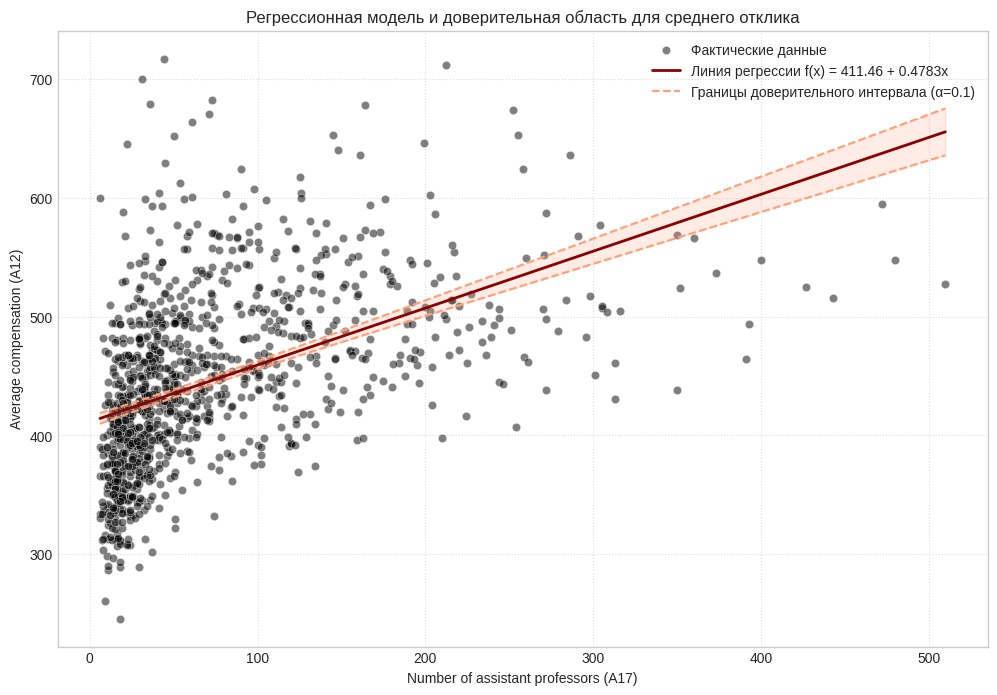

In [50]:
X = np.array(list_A17)
Y = np.array(list_A12)
n = len(X)


x_mean = np.mean(X)
S_xx = np.sum((X - x_mean)**2)


Y_pred = beta0 + beta1 * X


SSE = np.sum((Y - Y_pred)**2)
Se = np.sqrt(SSE / (n - 2))


alpha = 0.1
t_crit = st.t.ppf(1 - alpha/2, n - 2)


x_range = np.linspace(X.min(), X.max(), 100)
y_pred_range = beta0 + beta1 * x_range


se_y_hat_range = Se * np.sqrt(1/n + (x_range - x_mean)**2 / S_xx)

lower_bound = y_pred_range - t_crit * se_y_hat_range
upper_bound = y_pred_range + t_crit * se_y_hat_range


plt.figure(figsize=(12, 8))


sns.scatterplot(x=X, y=Y, color='black', alpha=0.5, label='Фактические данные')

plt.plot(x_range, y_pred_range, color='darkred', linewidth=2,
         label=f'Линия регрессии f(x) = {beta0:.2f} + {beta1:.4f}x')


plt.plot(x_range, lower_bound, color='lightsalmon', linestyle='--', label=f'Границы доверительного интервала (α={alpha})')
plt.plot(x_range, upper_bound, color='lightsalmon', linestyle='--')
plt.fill_between(x_range, lower_bound, upper_bound, color='lightsalmon', alpha=0.2)

plt.title('Регрессионная модель и доверительная область для среднего отклика')
plt.xlabel('Number of assistant professors (A17)')
plt.ylabel('Average compensation (A12)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

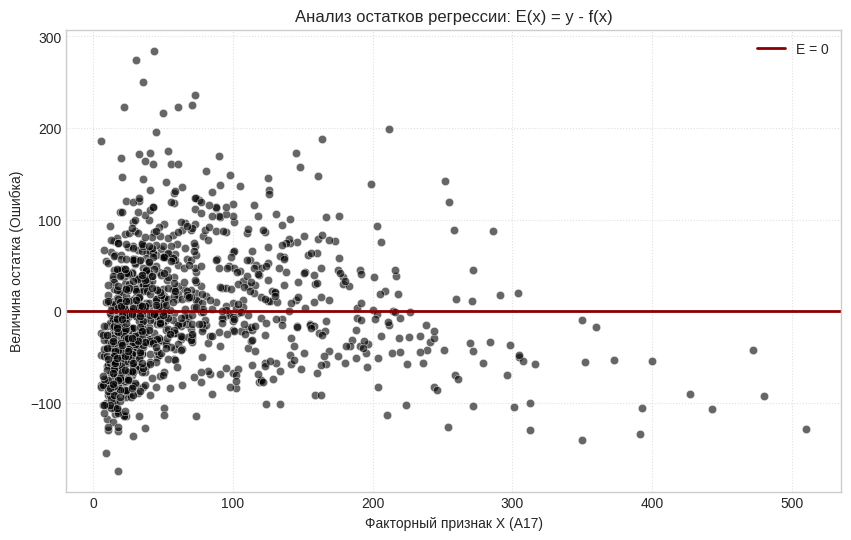

In [51]:
X = np.array(list_A17)
Y = np.array(list_A12)


Y_pred = beta0 + beta1 * X

Residuals = Y - Y_pred

plt.figure(figsize=(10, 6))

sns.scatterplot(x=X, y=Residuals, color='black', alpha=0.6)

plt.axhline(y=0, color='darkred', linestyle='-', linewidth=2, label='E = 0')

plt.title('Анализ остатков регрессии: E(x) = y - f(x)')
plt.xlabel('Факторный признак X (A17)')
plt.ylabel('Величина остатка (Ошибка)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [52]:
df_r, df_e = 1, n - 2
f_nabl = (ss_r / df_r) / (ss_e / df_e)
p_val = st.f.sf(f_nabl, df_r, df_e)


print(f"F-набл: {f_nabl:.4f}")
print(f"p-value: {p_val:.4e}\n")

for alpha in [0.01, 0.05, 0.1]:
    f_crit = st.f.ppf(1 - alpha, df_r, df_e)
    print(f"alpha {alpha}: F_крит = {f_crit:.4f}")

F-набл: 313.2378
p-value: 1.1020e-61

alpha 0.01: F_крит = 6.6586
alpha 0.05: F_крит = 3.8502
alpha 0.1: F_крит = 2.7102


In [53]:
x = np.array(list_A17)
y = np.array(list_A12)

X_mat = np.column_stack([np.ones(len(x)), x, x**2])

beta_q = np.linalg.inv(X_mat.T @ X_mat) @ X_mat.T @ y

beta0_q, beta1_q, beta2_q = beta_q

print(beta_q)

[ 3.89183259e+02  1.07249549e+00 -1.96381480e-03]


In [54]:
y_pred = X_mat @ beta_q
y_mean = np.mean(y)


ss_r = np.sum((y_pred - y_mean)**2)
ss_e = np.sum((y - y_pred)**2)
ss_t = np.sum((y - y_mean)**2)


df_r, df_e = 2, len(y) - 3
ms_r = ss_r / df_r
ms_e = ss_e / df_e


print(f"SSR: {ss_r:.2f}, SSE: {ss_e:.2f}, SST: {ss_t:.2f}")
print(f"MSR: {ms_r:.2f}, MSE: {ms_e:.2f}")

SSR: 1715802.34, SSE: 4192649.56, SST: 5908451.90
MSR: 857901.17, MSE: 3918.36


In [55]:
SSR_val = 1715802.34
SSE_val = 4192649.56
SST_val = 5908451.90

Sum_SS = SSR_val + SSE_val
Difference = abs(SST_val - Sum_SS)

print(f"D_регр: {SSR_val:.2f}, D_ост: {SSE_val:.2f}, D_общ: {SST_val:.2f}, Сумма: {Sum_SS:.2f}")

D_регр: 1715802.34, D_ост: 4192649.56, D_общ: 5908451.90, Сумма: 5908451.90


In [56]:
R2 = SSR_val / SST_val

eta = np.sqrt(R2)

print(f"Коэффициент детерминации: {R2:.4f}")
print(f"Корреляционное отношение: {eta:.4f}")

Коэффициент детерминации: 0.2904
Корреляционное отношение: 0.5389


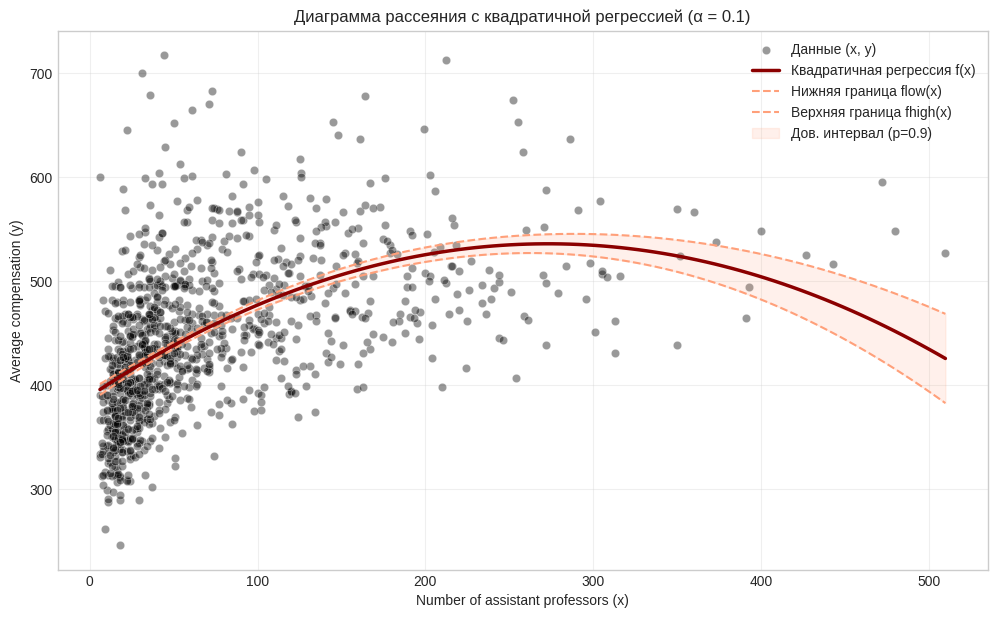

In [57]:
X = np.array(list_A17)
Y = np.array(list_A12)
n = len(X)
alpha = 0.1


X_mat = np.column_stack((np.ones(n), X, X**2))


beta = np.linalg.inv(X_mat.T @ X_mat) @ X_mat.T @ Y


Y_pred = X_mat @ beta
residuals = Y - Y_pred
mse = np.sum(residuals**2) / (n - 3)
s_e = np.sqrt(mse)


x_range = np.linspace(X.min(), X.max(), 100)
X_range_mat = np.column_stack((np.ones(100), x_range, x_range**2))
f_x = X_range_mat @ beta


C = np.linalg.inv(X_mat.T @ X_mat)
se_f = np.array([s_e * np.sqrt(x_0 @ C @ x_0.T) for x_0 in X_range_mat])


t_crit = st.t.ppf(1 - alpha/2, n - 3)


f_low = f_x - t_crit * se_f
f_high = f_x + t_crit * se_f


plt.figure(figsize=(12, 7))
sns.scatterplot(x=X, y=Y, color='black', alpha=0.4, label='Данные (x, y)')

plt.plot(x_range, f_x, color='darkred', linewidth=2.5, label='Квадратичная регрессия f(x)')
plt.plot(x_range, f_low, color='lightsalmon', linestyle='--', label='Нижняя граница flow(x)')
plt.plot(x_range, f_high, color='lightsalmon', linestyle='--', label='Верхняя граница fhigh(x)')

plt.fill_between(x_range, f_low, f_high, color='lightsalmon', alpha=0.15, label=f'Дов. интервал (p={1-alpha})')

plt.title(f'Диаграмма рассеяния с квадратичной регрессией (α = {alpha})')
plt.xlabel('Number of assistant professors (x)')
plt.ylabel('Average compensation (y)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

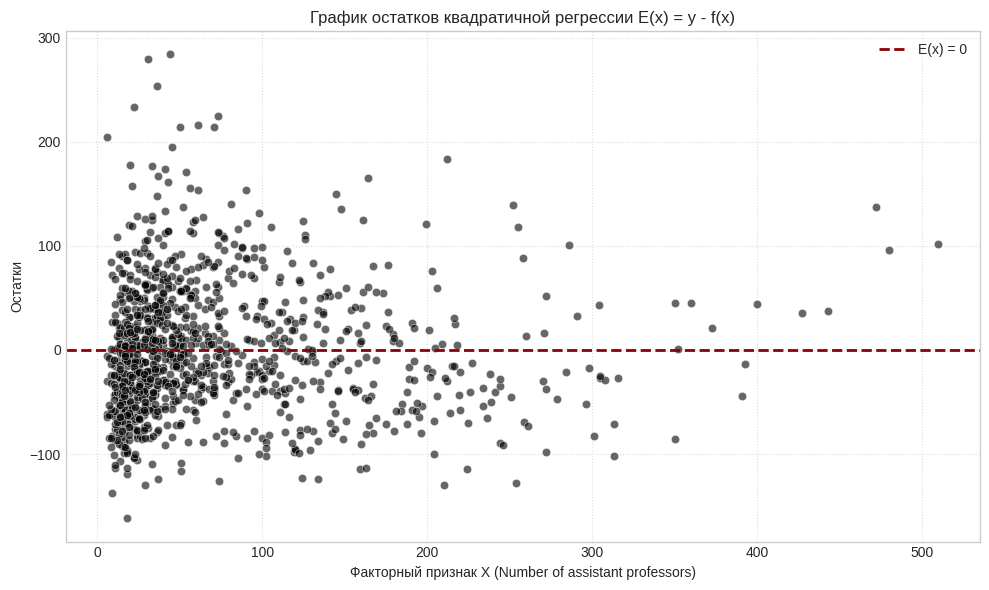

In [58]:
X = np.array(list_A17)
Y = np.array(list_A12)

b0, b1, b2 = 389.183, 1.0725, -0.001964
Y_pred_quad = b0 + b1*X + b2*(X**2)
Residuals_quad = Y - Y_pred_quad

plt.figure(figsize=(10, 6))

sns.scatterplot(x=X, y=Residuals_quad, color='black', alpha=0.6)

plt.axhline(y=0, color='darkred', linestyle='--', linewidth=2, label='E(x) = 0')

plt.title('График остатков квадратичной регрессии E(x) = y - f(x)')
plt.xlabel('Факторный признак X (Number of assistant professors)')
plt.ylabel('Остатки')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [59]:
n = 1073
k = 2
r_squared = 0.2904

f_obs = (r_squared / k) / ((1 - r_squared) / (n - k - 1))

p_value = st.f.sf(f_obs, k, n - k - 1)

print(f"Выборочное значение F-статистики (F_набл): {f_obs:.4f}")
print(f"p-value: {p_value:.4e}")

Выборочное значение F-статистики (F_набл): 218.9459
p-value: 1.9601e-80


In [60]:
x1 = np.array(list_A17)
x2 = np.array(list_A7)
y = np.array(list_A12)

X = np.column_stack((x1, x2))
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

b0, b1, b2 = model.params

In [61]:
ssr = model.ess
sse = model.ssr
sst = model.centered_tss

n = int(model.nobs)
k = 2
df_r = k
df_e = n - k - 1
df_t = n - 1

msr = ssr / df_r
mse = sse / df_e

print(f"SSR: {ssr:.2f}")
print(f"SSE: {sse:.2f}")
print(f"SST: {sst:.2f}")

print(f"MSR: {msr:.2f}")
print(f"MSE: {mse:.2f}")

SSR: 5583855.27
SSE: 324596.62
SST: 5908451.90
MSR: 2791927.64
MSE: 303.36


In [62]:
r_squared = model.rsquared

r_multiple = np.sqrt(r_squared)

print(f"Коэффициент детерминации: {r_squared:.4f}")
print(f"Множественный коэффициент корреляции: {r_multiple:.4f}")

Коэффициент детерминации: 0.9451
Множественный коэффициент корреляции: 0.9721


* Множественная линейная модель обладает сильной предсказательной способностью. Её точность составила 94.51%, что выше показателей простейшей линейной (22.63%) и квадратичной (29.04%) моделей
* Высокий скачок точности по сравнению с моделями, учитывающими только численность штата, объясняется включением в анализ средней зарплаты ассистентов. Статистически доказано, что именно уровень базового оклада является доминирующим фактором, формирующим итоговый размер компенсации